In [1]:
import sys
sys.path.insert(1, './cell2cell/')
from cell2cell.tensor.tensor import BaseTensor
import cell2cell as c2c

Guide to simulated cell-cell interactions, as defined by "communication scores" across multiple conditions. All arguments are set to work with tensor-cell2cell. When an option is required in order to work with tensor-cell2cell, it is explicitly stated

In [2]:
from c2c_sim.core.simulate import Simulate, CCI_MD

/home/hratch/anaconda3/envs/cci_dt/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Initialize the object:

In [3]:
sim = Simulate()

Generate the ligand-receptor PPI network. This will define all possible ligand-receptors (LR) that interact. If they do not interact for a given cell-cell (CC) pair, they LR "communication score" for that CC pair will be 0. 

In [4]:
# scale-free, randomly connected:
sim.LR_network(network_type = 'scale-free', **{'nodes': 100, 'degrees': 3, 'alpha': 2})

# # alternatively, randomly connected network with normal distribution:
# sim.LR_network(network_type = 'normal', **{'n_ligands': 500, 'n_receptors': 500, 'p': 0.5})

/home/hratch/Projects/cci_dt/tmpe1a3yd_w_bipartite_sf.csv
Generate undirected, bipartite, scale-free graph
Check network properties
All properties are as expected


/home/hratch/Projects/cci_dt/c2c_sim/core/graphs.py:164: UserWarning: 65 nodes are disconnected, removing from network
  warnings.warn(mssg)


Generate metadata associated with the LR IDs:

In [5]:
# the dictionary generates 3 subcategories with a "skew" of 0
# increasing skew will increasingly bias the binning of individual LR pairs into the subcategories
sim.LR.generate_metadata(n_LR_cats = {3: 0}, cat_skew = 0)
sim.LR.LR_metadata.head()

,LR_id,category,subcategory
0,"(0, 101)",81133daf1890,67ace7a038b3
1,"(0, 102)",81133daf1890,78112512d9f9
2,"(0, 103)",81133daf1890,67ace7a038b3
3,"(0, 104)",81133daf1890,ec59d640031d
4,"(0, 105)",81133daf1890,67ace7a038b3


Generate the CC metadata. Note that to work with tensor-cell2cell, the options directional and autocrine must be set to True, and remove_homotypic must equal 0. 

In [6]:
# generate cell metadata, accounting for directionality (sender vs receiver cells) and 
# allowing for autocrine interactions 

# note, to use with tensor-cell2cell, directional and autocrine must be True

cci = CCI_MD()
cci.cci_network(n_cells = 50, directional = True, autocrine = True)

# similarly generate metadata that each cell ID is associated with, do not remove homotypic interactions
cci.generate_metadata(n_cell_cats = {3: 0}, cat_skew = 0, remove_homotypic = 0)
# add cell metadata to simulation object
sim.cci = cci
sim.cci.cell_metadata.head()

,cell_id,category,subcategory
0,57952707f2bb,694a8fda8984,1a6ace61e7dc
1,0ca87f7af5b2,694a8fda8984,497a84b36d05
2,6b472f18d892,694a8fda8984,1a6ace61e7dc
3,0d9927f223e1,694a8fda8984,1a6ace61e7dc
4,f1a0322356a8,694a8fda8984,2518921f79f0


Generate the tensor metadata. This groups LR and CC subcategories into pairs that will have certain patterns and communication scores across conditions.

In [7]:
# generate 4 CC-LR groups that change across 12 conditions. 
# these changes can either be linear, oscillating, a pulse, or exponential
# allow homotypic interactions to form patterns - required for tensorcell2cell
# maximize the possible change in communication score

sim.generate_tensor_md(n_patterns = 4, n_conditions = 12, patterns = ['pulse', 'linear', 'oscillate', 'power'], 
                      consider_homotypic = True, score_change = 'max')
sim.clrm[['cell_subcat', 'LR_subcat', 'change', 'pattern', '0']]

/home/hratch/anaconda3/envs/cci_dt/lib/python3.9/site-packages/pandas/core/internals/blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)


,cell_subcat,LR_subcat,change,pattern,0
0,"(1a6ace61e7dc, 497a84b36d05)",67ace7a038b3,0.75,power,0.25
1,"(1a6ace61e7dc, 2518921f79f0)",67ace7a038b3,0.50,oscillate,0.50
2,"(497a84b36d05, 2518921f79f0)",67ace7a038b3,-0.75,pulse,0.75
3,"(2518921f79f0, 2518921f79f0)",67ace7a038b3,-1.00,linear,1.00


sim.clrm delineates the expected patterns and values. Each row represent an LR-CC group that changes together across condition. 0 is the average expected communication score at condition 0. Pattern is the expected temporal pattern in the communication score. Change represents the maximum change of the communication score from condition 0. 

---
Generate the actual values for each tensor slice. 

#### Part A: Complete the simulation for input to tensor-cell2cell. 
A baseline small value of noise is strongly recommended, otherwise the tensor sparsity effects the decomposition. Bulk must be set to true to work with tensor-cell2cell

In [8]:
# story a copy of sim object for single-cell visualization later (bulk required for tensor-cell2cell)
sim_sc = sim.copy()

In [9]:
sim.generate_tensor(noise = 0.01, bulk = True, noise_max = None)

/home/hratch/Projects/cci_dt/c2c_sim/core/simulate.py:716: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df.values[coords] = utils.get_truncated_normal(n = len(coords[0]),


Generate tensor outputs a dictionary stored in the attribute "ts". Each key is one of n_conditions, each value is a matrix with rows as LR pairs, columns as CC pairs, and values as communication scores

In [10]:
sim.ts['0'].head()

,"(1a6ace61e7dc, 1a6ace61e7dc)","(1a6ace61e7dc, 2518921f79f0)","(1a6ace61e7dc, 497a84b36d05)","(2518921f79f0, 1a6ace61e7dc)","(2518921f79f0, 2518921f79f0)","(2518921f79f0, 497a84b36d05)","(497a84b36d05, 1a6ace61e7dc)","(497a84b36d05, 2518921f79f0)","(497a84b36d05, 497a84b36d05)"
"(0, 101)",0.002411,0.497475,0.246813,0.004833,0.999557,0.000792,0.002754,0.743658,0.000685
"(0, 102)",0.001356,0.003554,0.000142,0.004114,0.001400,0.004593,0.000401,0.002103,0.003531
"(0, 103)",0.003850,0.499215,0.252113,0.000073,0.999952,0.002978,0.002997,0.747385,0.003600
"(0, 104)",0.000858,0.001961,0.000646,0.001918,0.003143,0.000134,0.001748,0.000848,0.003726
"(0, 105)",0.000954,0.499797,0.247760,0.001079,0.991203,0.001853,0.002534,0.755738,0.001026


decompose and visualize the tensor with tensor-cell2cell

In [11]:
sim.reshape() # format tensor for input to tensor-cell2cell
tensor = BaseTensor()
t1 = sim.sim_tensor.tensor_cci
tensor.tensor = t1
tensor.order_names = [['Context-{}'.format(c+1) for c in range(t1.shape[0])],
                      ['LR-{}'.format(c+1) for c in range(t1.shape[1])],
                      ['Sender-{}'.format(c+1) for c in range(t1.shape[2])],
                      ['Receiver-{}'.format(c+1) for c in range(t1.shape[3])]
                     ]

  0%|          | 0/12 [00:00<?, ?it/s]/home/hratch/Projects/cci_dt/c2c_sim/core/simulate.py:752: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tcs[coords] = ts.iloc[idx,:].values
 25%|██▌       | 3/12 [00:00<00:00, 20.00it/s]

Generate reshaped tensor


100%|██████████| 12/12 [00:00<00:00, 20.93it/s]


we expect the rank of the decomposition to equal the number of patterns generated; if background is detected, add 1 to the rank

  0%|          | 0/5 [00:00<?, ?it/s]

(<Figure size 288x162 with 1 Axes>,
 [(1, 0.4788566070139581),
  (2, 0.23240254028677895),
  (3, 0.21286101392531973),
  (4, 0.02034801566284029),
  (5, 0.01909036273061989)])

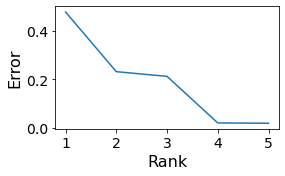

In [12]:
tensor.elbow_rank_selection(sim.sim_tensor.rank + 1)

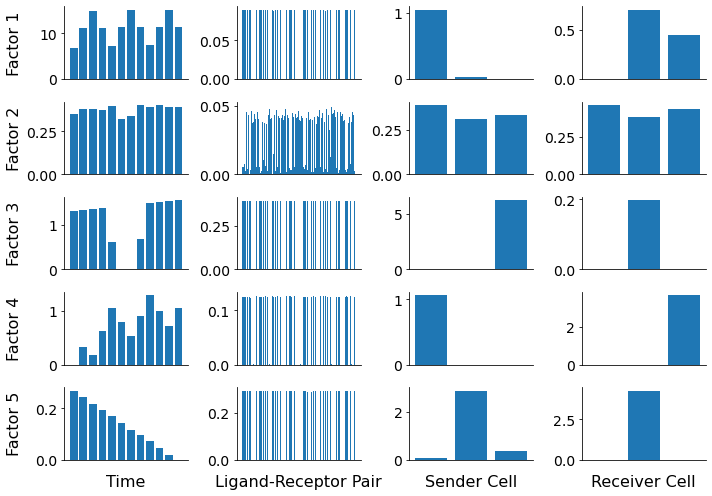

In [13]:
tensor.compute_tensor_factorization(rank=sim.sim_tensor.rank+1)
fig, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                             order_labels=['Time', 'Ligand-Receptor Pair', 'Sender Cell', 'Receiver Cell'],
                                             #metadata = tensor.order_names,
                                             #sample_col='Order',
                                             #group_col='Element',
                                             #meta_cmaps=['viridis', 'tab20', 'Pastel1', 'Pastel1'],
                                             fontsize=14# filename=fig_path + 'TF_SIM_v' + str(version) + '.svg'
                                            )

---
#### Part B: Visualize the actual patterns across conditions. 

We will proceed with a single-cell tensor instead, because it gives a larger distribution (50 cells vs 3 cell "types"). 

In [14]:
sim_sc.generate_tensor(noise = 0, bulk = False)

/home/hratch/Projects/cci_dt/c2c_sim/core/simulate.py:698: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df.values[coords] = avg_val # non-backgroun


/home/hratch/Projects/cci_dt/c2c_sim/core/simulate.py:809: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res_['score'] = self.ts[cond].values[self.clrm.loc[cat,'ts_coordinates']]


Generate graph


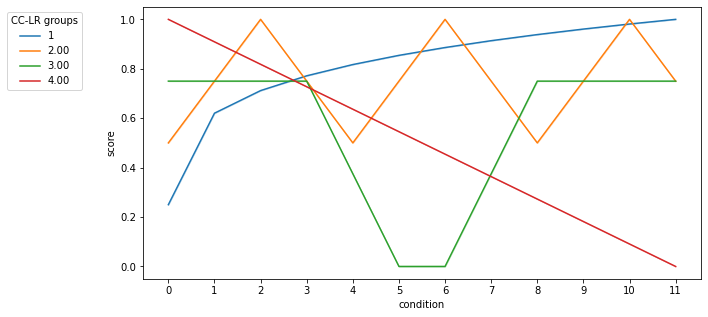

In [15]:
# # background_coords = sim_sc.get_background()
sim_sc.visualize(include_background = False, subset = None, background_coords = None, 
                file_name = None)